# Region of Interest (ROI) tutorial

This notebook is meant to teach the basics of what and how to utilize ROIs for computer vision goals. 

In [1]:
%matplotlib inline
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs


In [2]:
pcv.__version__

'3.14.3+2094.g2749a0c'

In [3]:
# Input/output options
args = WorkflowInputs(
    images=["multiplant.jpg"],    
    names="image1",
    result="roi_tutorial_results",
    outdir=".",
    writeimg=True,
    debug="plot",
    sample_label="brassica"
    )

In [4]:
# Set debug parameter
pcv.params.debug = args.debug
# Set (optional) parameters 
pcv.params.sample_label = args.sample_label
pcv.params.line_thickness = 2

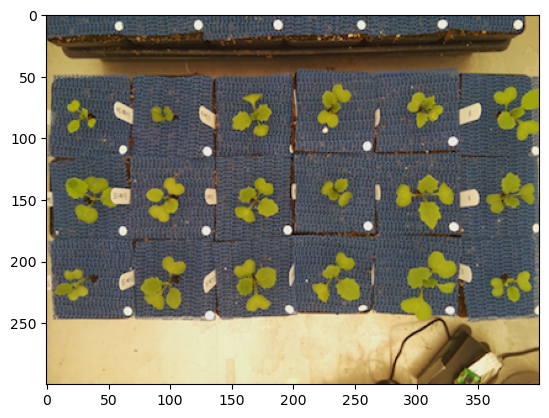

In [5]:
# Read in the garyscale data 
img, filename, path = pcv.readimage(filename=args.image1)

To isolate an object (or multiple objects in this example image) from the background, one or more regions of interest can be used to keep objects from one portion of the image. Often images contain noise around the border and we can filter these objects out by filtering on the Region that has the Objects of Interest (e.g. plants).

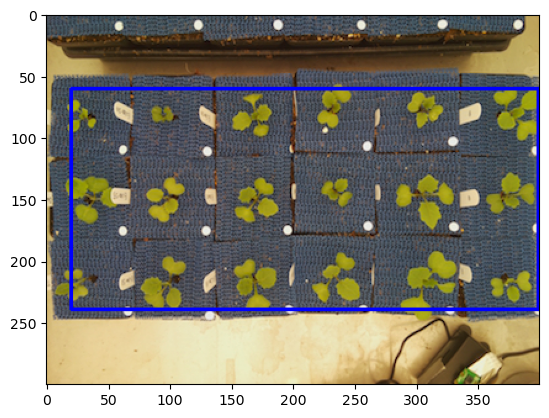

In [6]:
# Trays of plants often benefit from a rectangular ROI 
rect_roi = pcv.roi.rectangle(img=img, x=20, y=60, h=180, w=380)


The filtering actually happens on a binary mask where 0 (black) pixels are deselected and pixels with the value 255 (white) are what we want to segment out from the image. We know from test images that most plant material can be well segmented from a blue background with the `a` channel from the [LAB Colorspace](https://en.wikipedia.org/wiki/CIELAB_color_space). For more detail on segmentation in the context of computer vision and specific tools available within PlantCV please see our [threshold tutorial](https://plantcv.readthedocs.io/en/latest/tutorials/threshold_tutorial/). 

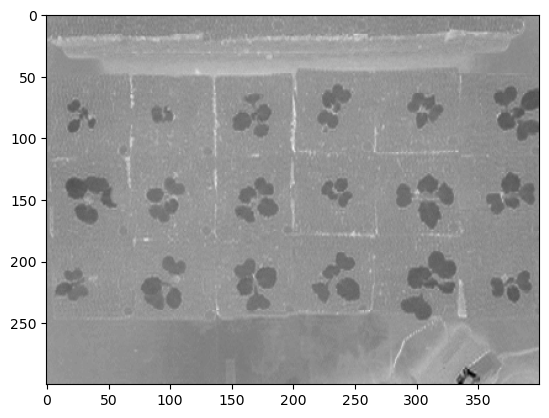

In [7]:
a_gray = pcv.rgb2gray_lab(rgb_img=img, channel="a")

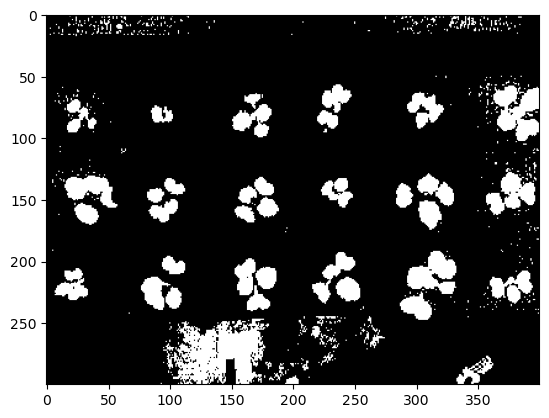

In [8]:
bin_mask = pcv.threshold.otsu(gray_img=a_gray, object_type="dark")

The majority of the the noise in the binary mask after doing an automatic theshold (using [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) in the above example) is at the bottom of the image. We can use the rectangular ROI that was created earlier to filter the mask and keep the objects within the region that we have determined to contain plants. For this reason, consistency of camera placement and positioning is very important if batch processing is desired over a large dataset of images, especially when the images are taken at different time points and by different people. 

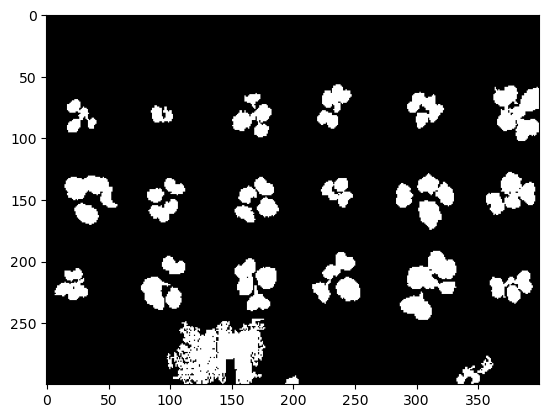

In [9]:
# Clean small noise first to help with the speed of the filtering step 

# Fill in small objects (if an object is smaller than the `size` input variable it will get removed)
cleaned_mask = pcv.fill(bin_img=bin_mask, size=50)



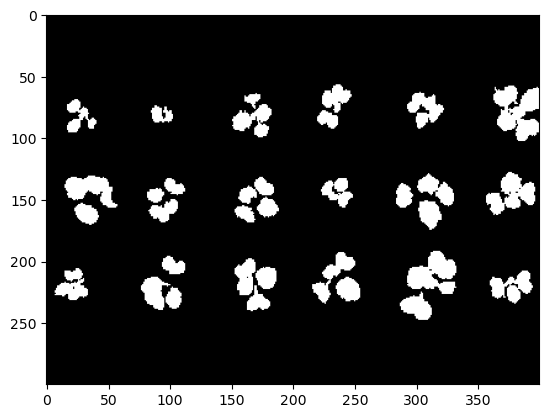

In [10]:
# Make a new filtered mask that only keeps the plants in your ROI and not objects outside of the ROI
# We have set to partial here so that if a leaf partially overlaps but extends outside of your ROI, it 
# will still be selected. 

# Inputs for the filtering function:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto' (hard cut off), or 
#                     'largest' (keep only largest object)

filtered_mask  = pcv.roi.filter(mask=cleaned_mask, roi=rect_roi, roi_type='partial')


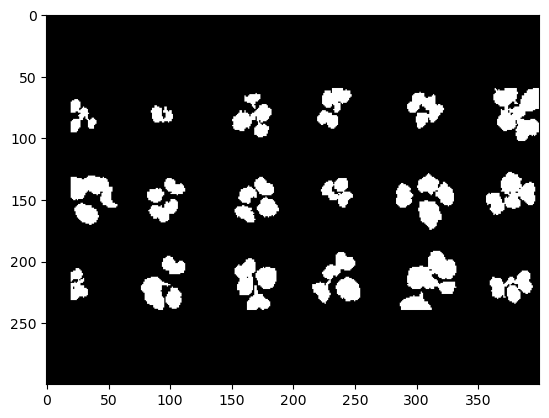

In [11]:
# What would it look like to use the "cutto" method? 

filtered_mask2  = pcv.roi.filter(mask=cleaned_mask, roi=rect_roi, roi_type='cutto')


Successfully filtered out non-plant material! Look ready to analyze? 

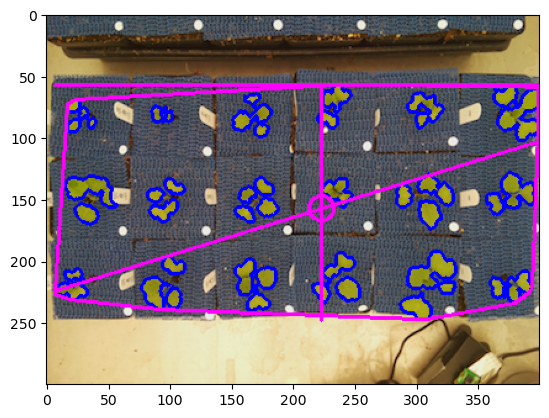

In [12]:
shape_img = pcv.analyze.size(img=img, labeled_mask=filtered_mask)

The annotations show that the entire tray is getting analyzed as a big, disconnected object even though we are successfully recognizing the plant material. Instead, we want to analyze each plant as a separate object so we can use another type of ROI to create a labeled mask 

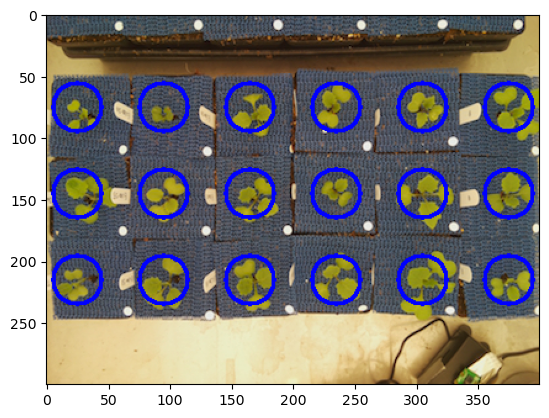

In [13]:
multi_roi = pcv.roi.multi(img=img, coord=(25,75), radius=20, spacing=(70, 70), nrows=3, ncols=6)

Small shifts in the camera or tray of plants can cause these hard-coded method for defining a grid of objects prone to issues in time-series datasets. Instead it's recommended to use the automatic grid detecting ROI tool isnce it also just saves time when you avoid needed to parameterize the starting coordinate and spacing of the grid. 

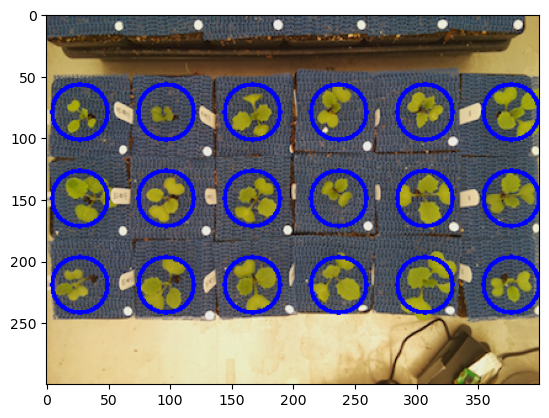

In [14]:
auto_rois = pcv.roi.auto_grid(mask=filtered_mask, nrows=3, ncols=6, img=img)


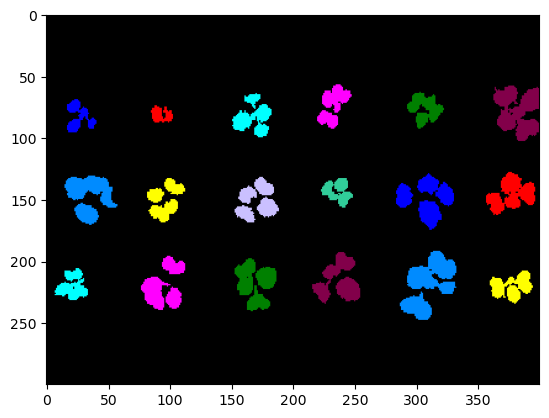

In [15]:
# Create a labeled mask, this function works very similarly to the roi.filter step above 
labeled_mask, num_plants = pcv.create_labels(mask=filtered_mask, rois=auto_rois, roi_type="partial")


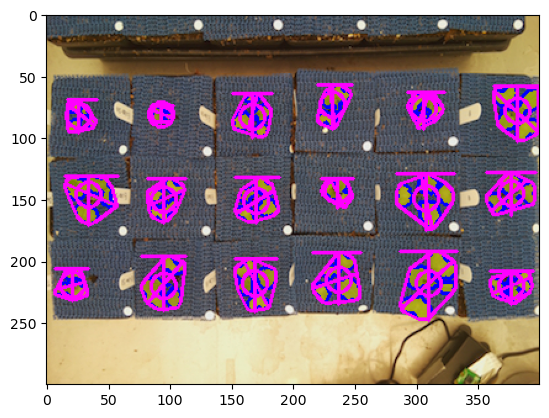

In [16]:
# Now we can finally extract size traits about each plant separately 
shape_img = pcv.analyze.size(img=img, labeled_mask=labeled_mask, n_labels=num_plants)

In [17]:
# Save stored data out to a file 

pcv.outputs.save_results(filename=args.result)
